based on : https://www.kaggle.com/CVxTz/keras-cnn-starter
# || Loading Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os, time, random, cv2, glob, pickle, librosa
from pathlib import Path
from PIL import Image
import imgaug as ia
from imgaug import augmenters as iaa
from tqdm import tqdm

from keras.models import Model
from keras.layers import (Convolution1D, Input, Dense, Flatten, Dropout, GlobalAveragePooling1D, concatenate,
                          Activation, MaxPool1D, GlobalMaxPool1D, BatchNormalization, Concatenate, ReLU, LeakyReLU)
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from keras.optimizers import Adam, SGD, RMSprop
from keras.losses import sparse_categorical_crossentropy
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
print(os.listdir("../input"))

Using TensorFlow backend.


['test', 'train_noisy.csv', 'train_curated.csv', 'train_curated', 'sample_submission.csv', 'train_noisy']


# || Configuration

In [2]:
%matplotlib inline
pd.set_option('max_colwidth', 400)
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 16
t_start = time.time()

# Keras reproduce score (then init all model seed)
# seed_nb=14
# import numpy as np 
# np.random.seed(seed_nb)
# import tensorflow as tf
# tf.set_random_seed(seed_nb)

# || Data Preparation

In [3]:
input_length = 16000*2

batch_size = 32

def audio_norm(data):

    max_data = np.max(data)
    min_data = np.min(data)
    data = (data-min_data)/(max_data-min_data+0.0001)
    return data-0.5


def load_audio_file(file_path, input_length=input_length):
    data = librosa.core.load(file_path, sr=16000)[0] #, sr=16000
    if len(data)>input_length:
        max_offset = len(data)-input_length
        offset = np.random.randint(max_offset)
        data = data[offset:(input_length+offset)]
        
    else:
        if input_length > len(data):
            max_offset = input_length - len(data)
            offset = np.random.randint(max_offset)
        else:
            offset = 0
            
        data = np.pad(data, (offset, input_length - len(data) - offset), "constant")
        
    data = audio_norm(data)
    return data

In [4]:
train_files = glob.glob("../input/train_curated/*.wav")
test_files = glob.glob("../input/train_noisy/*.wav")
train_labels = pd.read_csv("../input/train_curated.csv")

In [5]:
file_to_label = {"../input/train_curated/"+k:v for k,v in zip(train_labels.fname.values, train_labels.labels.values)}

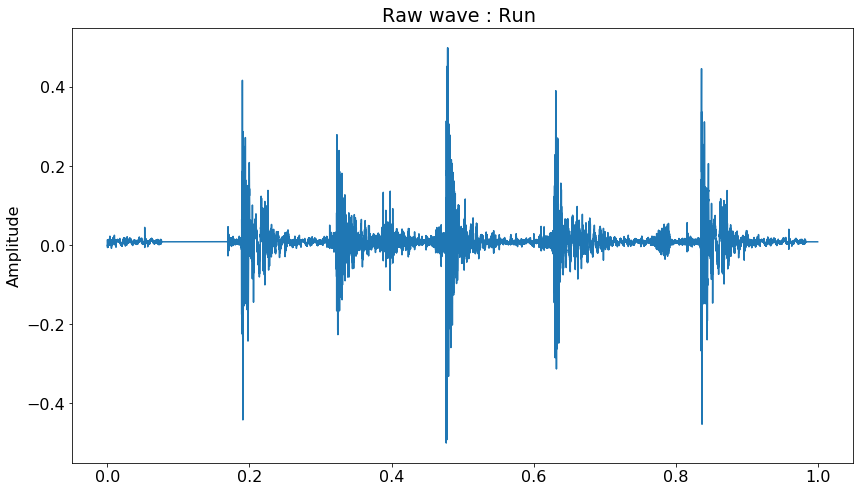

In [6]:
data_base = load_audio_file(train_files[0])
fig = plt.figure(figsize=(14, 8))
plt.title('Raw wave : %s ' % (file_to_label[train_files[0]]))
plt.ylabel('Amplitude')
plt.plot(np.linspace(0, 1, input_length), data_base)
plt.show();

In [7]:
list_labels = sorted(list(set(train_labels.labels.values)))
label_to_int = {k:v for v,k in enumerate(list_labels)}
int_to_label = {v:k for k,v in label_to_int.items()}
file_to_int = {k:label_to_int[v] for k,v in file_to_label.items()}

In [8]:
def get_model():
    nclass = len(list_labels)
    inp = Input(shape=(input_length, 1))
    img_1 = Convolution1D(16, kernel_size=9, activation="relu", padding="valid")(inp)
    img_1 = Convolution1D(16, kernel_size=9, activation="relu", padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=16)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation="relu", padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation="relu", padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=4)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation="relu", padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation="relu", padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=4)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation="relu", padding="valid")(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation="relu", padding="valid")(img_1)
    img_1 = GlobalMaxPool1D()(img_1)
    img_1 = Dropout(rate=0.2)(img_1)

    dense_1 = Dense(64, activation="relu")(img_1)
    dense_1 = Dense(1028, activation="relu")(dense_1)
    dense_1 = Dense(nclass, activation="softmax")(dense_1)

    model = Model(inputs=inp, outputs=dense_1)

    model.compile(optimizer=Adam(0.001), loss=sparse_categorical_crossentropy, metrics=['acc'])
    model.summary()
    return model

In [9]:
def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

In [10]:
def train_generator(list_files, batch_size=batch_size):
    while True:
        random.shuffle(list_files)
        for batch_files in chunker(list_files, size=batch_size):
            batch_data = [load_audio_file(fpath) for fpath in batch_files]
            batch_data = np.array(batch_data)[:,:,np.newaxis]
            batch_labels = [file_to_int[fpath] for fpath in batch_files]
            batch_labels = np.array(batch_labels)
            
            yield batch_data, batch_labels

In [11]:
tr_files, val_files = train_test_split(train_files, test_size=0.1)

In [12]:
model = get_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32000, 1)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 31992, 16)         160       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 31984, 16)         2320      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1999, 16)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1999, 16)          0         
_________________________________________________________________
conv1d_3 (Conv1D)    

In [14]:
model.fit_generator(train_generator(tr_files), 
                    steps_per_epoch=len(tr_files)//batch_size, 
                    validation_data=train_generator(val_files),
                    validation_steps=len(val_files)//batch_size,
                    epochs=1
    )

Epoch 1/1
139/139 [==============================] - 1384s 10s/step - loss: 4.7217 - acc: 0.0110 - val_loss: 4.7379 - val_acc: 0.0125


In [15]:
model.save_weights("baseline_cnn.h5")

In [16]:
list_preds = []

In [ ]:
for batch_files in tqdm(chunker(test_files, size=batch_size), total=len(test_files)//batch_size ):
    batch_data = [load_audio_file(fpath) for fpath in batch_files]
    batch_data = np.array(batch_data)[:,:,np.newaxis]
    preds = model.predict(batch_data).tolist()
    list_preds += preds

  7%|▋         | 44/619 [12:58<2:49:25, 17.68s/it]

In [ ]:
array_preds = np.array(list_preds)
list_labels = np.array(list_labels)

top_3 = list_labels[np.argsort(-array_preds, axis=1)[:, :3]]
pred_labels = [' '.join(list(x)) for x in top_3]

In [ ]:
df = pd.DataFrame(test_files, columns=["fname"])
df['label'] = pred_labels

In [ ]:
df['fname'] = df.fname.apply(lambda x: x.split("/")[-1])

In [ ]:
df.to_csv("baseline.csv", index=False)

In [ ]:
t_finish = time.time()
print(f"Kernel run time = {(t_finish-t_start)/3600} hours")